# Regularized Linear Model
## Javier Palomares
### Question 2   
Follow the data preprocessing steps from https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/
regularized-linear-models. Then run a ridge regression using $\alpha = 0.1$. Make a submission of this prediction, what is the RMSE you get?
(Hint: remember to exponentiate np.expm1(ypred) your predictions).


#### Preprocessing

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr


%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

In [72]:
train = pd.read_csv("./input/train.csv")
test = pd.read_csv("./input/test.csv")

In [73]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [74]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

Data preprocessing:
We're not going to do anything fancy here:

* First I'll transform the skewed numeric features by taking log(feature + 1) - this will make the features more normal
* Create Dummy variables for the categorical features
* Replace the numeric missing values (NaN's) with the mean of their respective columns

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6a99b46748>,
      dtype=object)

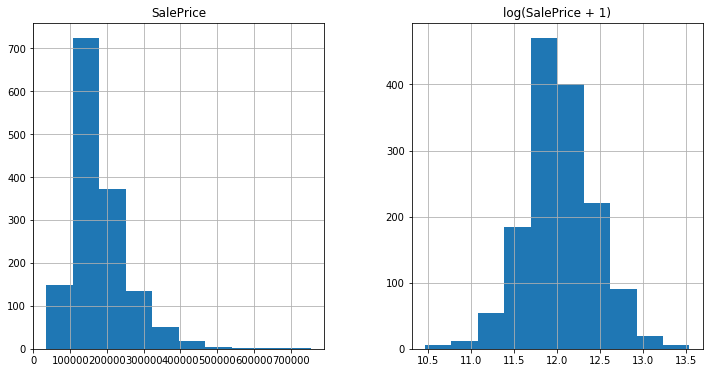

In [75]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
prices = pd.DataFrame({"SalePrice":train["SalePrice"], "log(SalePrice + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [76]:
# log transform the sale price
train["SalePrice"] = np.log1p(train["SalePrice"])

# get the numberical features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# compute the skeweness factor of features
# take features with factor greater than .75
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

# take the log of all skewed features
all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [77]:
# Convert categorical variable into dummy/indicator variables
all_data = pd.get_dummies(all_data)

In [78]:
# filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())

In [79]:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

#### Models
Now we are going to use regularized linear regression models from the scikit learn module. I'm going to try both l_1(Lasso) and l_2(Ridge) regularization. I'll also define a function that returns the cross-validation rmse error so we can evaluate our models and pick the best tuning par

In [80]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

In [81]:
# function to compute the root mean squared error of the cross validation
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)


We'll run a ridge regression using a value of $\alpha=0.1$

In [82]:
alpha = .1
ridge_model = Ridge(alpha=alpha)

In [83]:
cv_rmse_ridge = rmse_cv(ridge_model).mean()

In [84]:
print(cv_rmse_ridge)

0.13777538277187826


The ridge model gives a cross validation rmse of .1377 when $\alpha=.1$

In [85]:
# fit the model then get the y predicted
ridge_model.fit(X_train,y)
y_pred = ridge_model.predict(X_train)
# we took a log of the sale price in the pre processing, so we need to exponentiate y_pred and y to get the true sale prices
y_pred = np.expm1(y_pred)
y = np.expm1(y)

In [86]:
def rms(predicted,target):
    return np.sqrt(np.mean((predicted-target)**2))

In [87]:
rmse_ridge = rms(y_pred,y)
print("using alpha = 0.1, Ridge regression had an rmse of {}".format(rmse_ridge))

using alpha = 0.1, Ridge regression had an rmse of 17965.974938885876


### Question 3
Compare a ridge regression and a lasso regression model. Optimize the alphas using cross
validation. What is the best score you can get from a single ridge regression model and from
a single lasso model?